In [5]:
import pandas as pd
import numpy as np
import netCDF4
import os
import geopandas as gpd
from shapely import vectorized, geometry
import shapely
import matplotlib.pyplot as plt
%pylab inline
import sqlite3 as sql3

Populating the interactive namespace from numpy and matplotlib


## Set Up Climate Zone Processing

In [6]:
bbox = (240.9375, 33.4375, 243.1875, 34.9375)
step = 0.125

lats = (np.array(np.linspace(bbox[1], bbox[3],
        int(1 + (bbox[3] - bbox[1])/step)), 
        dtype=np.float32))

lons = (np.array(np.linspace(bbox[0], bbox[2],
        int(1 + (bbox[2] - bbox[0])/step)),
        dtype=np.float32) - 360)

latlon = np.vstack(np.dstack(np.meshgrid(lons, lats)))

In [8]:
homedir = os.path.expanduser('~')
climzone = gpd.read_file('%s/Dropbox/Projects/2013 - LA Baselines/LA Baseline Data Share ASU Internal/LA GIS Layers/Climate Zones/los angeles climate zones/Climate Zones/CA_Building_Standards_Climate_Zones/CA_Building_Standards_Climate_Zones.shp' % homedir).to_crs(epsg=4326)

NameError: name 'gpd' is not defined

In [4]:
intersection = climzone.set_index('Zone').geometry.apply(lambda x: np.where(vectorized.contains(x, latlon[:,0], latlon[:,1]))[0])
intersection = intersection[intersection.apply(len) > 0]

In [5]:
zone_idx = pd.Series(np.concatenate(intersection.values), index=np.repeat(intersection.index.values, intersection.apply(len)))
idx_xy = zone_idx.apply(lambda x: np.unravel_index(x, (lats.size, lons.size))).apply(pd.Series).rename(columns={0: 'y', 1: 'x'})

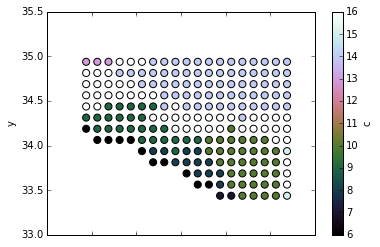

In [6]:
plot_df = pd.concat([idx_xy['x'].apply(lambda x: lons[x]), idx_xy['y'].apply(lambda y: lats[y])], axis=1).reset_index().rename(columns={'index':'c'})

plot_df.astype(float).plot(kind='scatter', x='x', y='y', c='c', colormap='cubehelix', s=50)

In [7]:
for zone in np.unique(idx_xy.index.values):
    c= len(idx_xy.loc[zone])
    print zone, c

10 34
13 3
14 67
15 2
16 48
6 11
7 2
8 12
9 25


## Map Downscaled geographies to Climate Zones 

In [11]:
def climate_zone_var(nc, idx_xy, start_date, freq='D', col_labels=['x', 'y']):

    cz_dict = {}
    
    for zone in np.unique(idx_xy.index.values):
        c = idx_xy.loc[zone]
        tmax = np.nanmean(nc[:, c[col_labels[1]].values, c[col_labels[0]].values], axis=1)
        cz_dict.update({ zone : tmax})

    cz_var = pd.DataFrame.from_dict(cz_dict)
    cz_var.index = pd.date_range(start=start_date, periods=len(cz_var), freq='D')
    
    return cz_var

In [12]:
def nctodf(nc, idx_xy, start_date, freq='D', col_labels=['x', 'y']):

    cz_dict = {}
    
    for zone in np.unique(idx_xy.index.values):
        c = idx_xy.loc[zone]
        tmax = np.nanmean(nc[:, c[col_labels[1]].values, c[col_labels[0]].values], axis=1)
        cz_dict.update({ zone : tmax})

    cz_var = pd.DataFrame.from_dict(cz_dict)
    cz_var.index = pd.date_range(start=start_date, periods=len(cz_var), freq='D')
    
    return cz_var,tmax

In [13]:
nc = netCDF4.Dataset('RCP4.5/acc/Extraction_tasmax.nc')
var=nc.variables['tasmax'][:]
times=netCDF4.num2date(nc.variables['time'][:],nc.variables['time'].units)
starttime=times[0].replace(hour=0, minute=0)
nctodf(var[0,:,:,:],idx_xy,starttime)[1]

masked_array(data = [14.75908088684082 19.400331497192383 19.046619415283203 ...,
 21.645553588867188 23.8668270111084 22.256160736083984],
             mask = [False False False ..., False False False],
       fill_value = 1e+20)

## Import Climate Predictions

In [14]:
def nc_import(filename, variable, projection):
    nc = netCDF4.Dataset(filename)
    var=nc.variables[variable][:]
    times=netCDF4.num2date(nc.variables['time'][:],nc.variables['time'].units)
    proj=np.ma.filled(var[projection,:,:,:])# Single projection, all locations
    #cz_var = climate_zone_var(proj,idx_xy,times[0])#Projection hard-coded here
    starttime=times[0].replace(hour=0, minute=0)
    cz_var=climate_zone_var(var[projection,:,:,:],idx_xy,starttime)
    LAC_var=cz_var.loc[:,('6','8','9','14','16')]
    return LAC_var#,starttime

In [15]:
def define_series(Basename, proj):
    LAC_tmax=nc_import(Basename+'/Extraction_tasmax.nc',"tasmax",proj)
    LAC_tmin=nc_import(Basename+'/Extraction_tasmin.nc','tasmin',proj)
    LAC_tmax=LAC_tmax[~((LAC_tmax.index.month==2) & (LAC_tmax.index.day==29))]#Remove Leap Year
    LAC_tmin=LAC_tmin[~((LAC_tmin.index.month==2) & (LAC_tmin.index.day==29))]#Remove Leap Year
    #LAC_tas=nc_import(Basename+'/Extraction_Tavg.nc','Tavg',proj)
    LAC_pr=nc_import(Basename+'/Extraction_pr.nc',"pr",proj)
    #LAC_pr=1
    return LAC_tmax, LAC_tmin, LAC_pr

## Import Base CZ data from EPWs

In [16]:
import datetime
def EPW_proc(filename, CZ):
    with open(filename, 'r') as f:
        content=f.read().split('\r\n')[8:-1]
    content=[x.split(',') for x in content]
    dct={}
    pdct={}
    for row in content:
        stamp=datetime.datetime(2010,int(row[1]),int(row[2]),int(row[3])-1)
        #print row[3]
        temp=float(row[6])
        prec=float(row[-2])
        dct[stamp]=temp
        pdct[stamp]=prec
    df=pd.DataFrame.from_dict(dct, orient='index').sort()
    df.columns=[str(CZ)]
    pdf=pd.DataFrame.from_dict(pdct, orient='index').sort()
    pdf.columns=[str(CZ)]
    return df, pdf

In [17]:
[cz8,p8]=EPW_proc('CZ08RV2.epw',8)
[cz6,p6]=EPW_proc('CZ06RV2.epw',6)
[cz9,p9]=EPW_proc('CZ09RV2.epw',9)
[cz14, p14]=EPW_proc('CZ14RV2.epw',14)
[cz16, p16]=EPW_proc('CZ16RV2.epw',16)
data=pd.concat([cz6,cz8,cz9,cz14,cz16],axis=1)
prec=pd.concat([p6,p8,p9,p14,p16], axis=1)

## Dry Bulb Temperature

In [18]:
def drybulbtemp(firstyr, lastyr,folder,proj):
    [LAC_tmax, LAC_tmin, LAC_pr]=define_series(folder, proj)
    rng = pd.DataFrame(index=pd.date_range('12/31/'+str(lastyr), periods=24, freq='H')[1:],columns=["6","8","9","14","16"])
    LAC_tmax=LAC_tmax[str(firstyr):str(lastyr)].resample('H').append(rng).ffill()
    LAC_tmin=LAC_tmin[str(firstyr):str(lastyr)].resample('H').append(rng).ffill()
    LAC_tmax=LAC_tmax[~((LAC_tmax.index.month==2) & (LAC_tmax.index.day==29))]#Remove Leap Year
    LAC_tmin=LAC_tmin[~((LAC_tmin.index.month==2) & (LAC_tmin.index.day==29))]#Remove Leap Year
    LAC_dtr=LAC_tmax-LAC_tmin
    rng = pd.DataFrame(index=pd.date_range('12/31/2010', periods=24, freq='H')[1:],columns=["6","8","9","14","16"])
    a=data.resample('D',how=max)
    hourmax=a.resample('H').append(rng).ffill()
    b=data.resample('D',how=min)
    hourmin=b.resample('H').append(rng).ffill()
    epw_dtr=hourmax-hourmin
    output=[]
    for yr in [str(x) for x in list(set(LAC_dtr.index.year))]:
        times = pd.to_datetime(LAC_dtr[yr].index)
        data2=data.set_index(times)
        hourmin=hourmin.set_index(times)
        output.append(LAC_dtr[yr].div( epw_dtr.values)*(data2-hourmin)+LAC_tmin[yr])
    output=pd.concat(output)
    output=pd.rolling_mean(output, window=4, min_periods=1)
    return output

## Precipitation

In [19]:
def rain(firstyr, lastyr,folder,proj):
    [LAC_tmax, LAC_tmin, LAC_pr]=define_series(folder, proj)
    rng = pd.DataFrame(index=pd.date_range('12/31/'+str(lastyr), periods=24, freq='H')[1:],columns=["6","8","9","14","16"])
    LAC_pr=LAC_pr[str(firstyr):str(lastyr)].resample('H').append(rng).ffill()
    return LAC_pr

## Output to EPW

In [21]:
var_position={"Temp":6, "Rain":12}


In [22]:
def EPW_write(year_range, rcp, model, run):
    # Read Header, write directly to output
    # Row by row read base EPW, replace selected variables, recreate non-selected
    # Two options: repeat this process for every year in range OR
    # Simultaneously write all years (need a lot of files open)
    output=drybulbtemp(min(year_range), max(year_range),'RCP'+str(rcp)+'/'+str(model),run)
    for CZ in ['16']:#,'08','09','14','16']:
        filename='CZ'+CZ+'RV2.epw'
        with open(filename, 'r') as f:
            header=f.read().split('\r\n')[0:8]
        with open(filename, 'r') as f:
            content=f.read().split('\r\n')[8:-1]
        content=[x.split(',') for x in content]
        for yr in year_range:
            #tempdata=output[(output.index.year == yr)].loc[:,[str(CZ)]]
            newname=filename[:-7]+'_'+str(yr)+'_'+str(rcp)+'_'+str(model)+'_'+str(run)+'.epw'
            with open(newname, 'w') as o:
                for line in header:
                    o.write(line+'\r\n')
                for line in content:
                    date=str(yr)+'-'+str(line[1])+'-'+str(line[2]) +' '+ str(int(line[3])-1)+':00'
                    line[6]=str(output.loc[date,str(int(CZ))])
                    o.write(','.join(line)+'\r\n')
    return header, content

In [34]:
testyears=[[x] for x in range(2022,2061)]
testyears=[[2022]]
for yr in testyears:
    [header, content]=EPW_write(yr,6.0, 'bcc',0)
    [header, content]=EPW_write(yr,6.0, 'ccs',0)
    [header, content]=EPW_write(yr,6.0, 'ccs',1)
    [header, content]=EPW_write(yr,6.0, 'gfc',0)
    [header, content]=EPW_write(yr,6.0, 'gfg',0)
    [header, content]=EPW_write(yr,6.0, 'gfm',0)
    [header, content]=EPW_write(yr,6.0, 'ipl',0)
    [header, content]=EPW_write(yr,6.0, 'ipm',0)
    [header, content]=EPW_write(yr,6.0, 'mri',0)
    [header, content]=EPW_write(yr,6.0, 'nor',0)
 

In [44]:
dct={}
dct['2.6']=['bcc0','ccs0','ccs1','gfc0','gfg0','ipm0','mir1','mpl0','mpl1','mpl2']
dct['4.5']=['acc0','ccs0','ccs1','cnr0','gfg0','inm0','mir1','mpl0','mpl1','mpl2']
dct['6.0']=['bcc0','ccs0','ccs1','gfc0','gfg0','gfm0','ipl0','ipm0','mri0','nor0']
dct['8.5']=['acc0','ccs0','ccs1','cnr0','gfg0','inm0','mir1','mpl0','mpl1','mpl2']
def wstrp(dct,cz):
    mstdct={}
    for d in dct:
        mstdct[d]=[]
        for ele in dct[d]:
            mstdct[d].append(drybulbtemp(2020,2060,'RCP'+d+'/'+ele[:-1],int(ele[-1])).resample('a')[cz])
        mstdct[d]=pd.concat(mstdct[d],axis=1)
    return mstdct

#output=drybulbtemp(2020, 2060,'RCP2.6/bcc',0).resample('a',how='sum')
#output.to_excel('2.6.xlsx','bcc0')

In [56]:
db='/Users/janet/Dropbox/Projects/2015 - Dissertation/Energy Simulation/Results/Forecasting/ConstantLoads.db'
def d_weather(rcp,cz):
    cz=str(cz)
    mstdct=[]
    for ele in dct[rcp]:
        mstdct.append(drybulbtemp(2020,2060,'RCP'+rcp+'/'+ele[:-1],int(ele[-1]))[cz])
    mstdct=pd.concat(mstdct,axis=1).resample('d', how='mean')
    elec=pd.DataFrame(0,index=mstdct.index,columns=["median","average","max","min"])
    elec["median"]=mstdct.median(axis=1)
    elec["average"]=mstdct.mean(axis=1)
    elec["max"]=mstdct.max(axis=1)
    elec["min"]=mstdct.min(axis=1)
    nm='weather_'+''.join(rcp.split('.'))+'_'+cz
    write_sql3(db,elec,nm)
    return elec

In [59]:
for ele in ['2.6','4.5','6.0']:
    d_weather(ele,9)

In [49]:
def write_sql3(db,df,name):
    conn=sql3.connect(db)
    c=conn.cursor()
    query="SELECT count(*) FROM sqlite_master WHERE type='table' AND name='" +name +"';"#'s1_85_a';"
    c.execute(query)
    t=c.fetchall()
    if t==[(1,)]:
        drop_table(db,name)
    df.to_sql(name,conn)
    conn.close()

In [4]:
def cdd_calc(rcp):
    case=[]
    for d in dct[rcp]:
        temptime=drybulbtemp(2020,2060,'RCP'+rcp+'/'+d[:-1],int(d[-1])).resample('d', how='mean')-18.3
        temptime=temptime[temptime>0].resample('a',how='sum')
        case.append(temptime) 
        a=case[0].copy() 
        for ele in case[1:]:
            a+=ele
    return a/10

In [3]:
def ac_sat_increase(rcp):
    test2=pd.rolling_mean(cdd_calc(rcp),window=4, min_periods=1)
    base=data.resample('d', how='mean')-18.3
    cztp=base[base>0].resample('a',how='sum')
    deltcdd=test2.sub(cztp.squeeze()) 
    term1=np.exp(test2*-.00298)*.00349
    inc=term1*deltcdd
    inc[inc<0]=0
    inc=fill_loop(inc)
    inc=fill_loop(inc)
    inc=fill_loop(inc)
    inc=fill_loop(inc)
    inc=fill_loop(inc)
    inc=fill_loop(inc)
    inc.to_excel('sat_change.xlsx',rcp)
    return inc

In [2]:
def fill_loop(inc):
    fstrow=inc['2020']
    df=inc.diff()
    inc=inc[df>0].ffill()
    inc['2020']=fstrow
    inc=inc.ffill()
    return inc

In [36]:
ac_sat_increase('2.6')

,6,8,9,14,16
2020-12-31,0.118894,0.028342,0.004927,0.021360,0.281130
2021-12-31,0.118894,0.028342,0.004927,0.021360,0.281130
2022-12-31,0.118894,0.028342,0.004927,0.021360,0.281130
2023-12-31,0.118894,0.028342,0.004927,0.021360,0.281130
2024-12-31,0.118894,0.028342,0.004927,0.021360,0.281130
2025-12-31,0.126752,0.036452,0.005849,0.021380,0.281130
2026-12-31,0.135249,0.043905,0.012518,0.021787,0.281130
2027-12-31,0.135249,0.043905,0.012518,0.021787,0.281130
2028-12-31,0.135249,0.043905,0.012518,0.021795,0.281130
2029-12-31,0.135249,0.043905,0.012518,0.021795,0.281130


In [25]:
def weathercreate(cz):
    b=wstrp(dct,cz)
    meh={}
    meh['8.5']=b['8.5'].mean(axis=1)
    meh['6.0']=b['6.0'].mean(axis=1)
    meh['4.5']=b['4.5'].mean(axis=1)
    meh['2.6']=b['2.6'].mean(axis=1)
    return meh
    

In [23]:
wcz6=weathercreate("6")

In [25]:
wcz8=weathercreate("8")

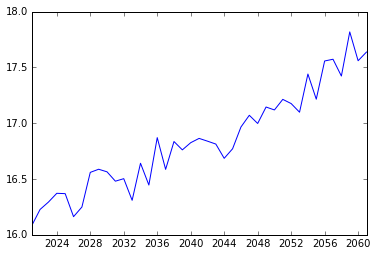

In [32]:
plt.plot(wcz6['8.5'].index,wcz6['8.5'])

In [41]:
wcz9=weathercreate("9")
wcz14=weathercreate("14")
wcz16=weathercreate("16")

In [53]:
wcz={}
wcz[6]=wcz6
wcz[8]=wcz8
wcz[9]=wcz9
wcz[14]=wcz14
wcz[16]=wcz16

In [55]:
for cz in [6,8,9,14,16]:
    for rcp in ["2.6","4.5","6.0","8.5"]:
        flname="CZ%s_RCP%s.csv"%(cz,rcp)
        dta=wcz[cz][rcp]
        dta.to_csv(flname)

In [36]:
cz=16
wcz16={}
for rcp in ["2.6","4.5","6.0","8.5"]:
    flname="CZ%s_RCP%s.csv"%(cz,rcp)
    fle=pd.read_csv(flname,header=0, names=["date","temp"],index_col="date")
    fle.index=pd.to_datetime(fle.index)
    wcz16[rcp]=fle
        

In [41]:
def weatherplot(rcp):
    plt.plot(wcz6[rcp].index, wcz6[rcp], color='magenta', label='CZ 6')
    plt.plot(wcz8[rcp].index, wcz8[rcp], color='purple', label='CZ 8')
    plt.plot(wcz9[rcp].index,wcz9[rcp] , color='blue', label='CZ 9')
    plt.plot(wcz14[rcp].index,wcz14[rcp], color='orange', label='CZ 14')
    plt.plot(wcz16[rcp].index,wcz16[rcp], color='green', label='CZ 16')
    plt.ylim([13,20])
    plt.ylabel('Average Temperature (C)')
    plt.xlabel('Year')
    #plt.legend(title='Climate Zone',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
    title='RCP %s' %rcp
    plt.title(title)


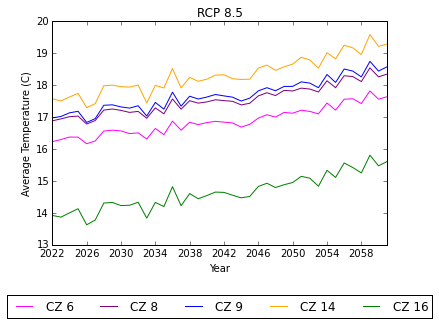

In [42]:
weatherplot('8.5')

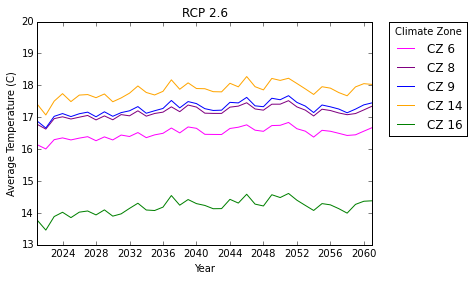

In [50]:
weatherplot('2.6')

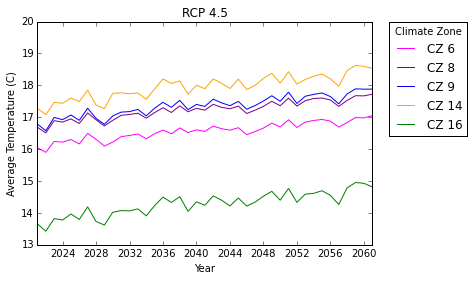

In [51]:
weatherplot('4.5')

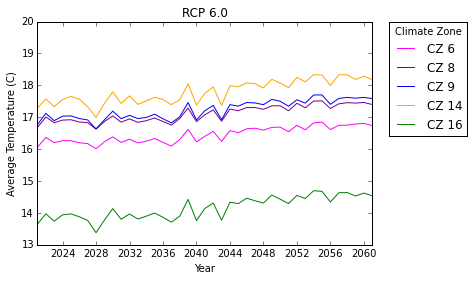

In [52]:
weatherplot('6.0')

In [21]:
b=wstrp(dct,"6")
#b['8.5']
#meh85=b['8.5'].mean(axis=1)
#meh60=b['6.0'].mean(axis=1)
#meh45=b['4.5'].mean(axis=1)
#meh26=b['2.6'].mean(axis=1)
#plt.plot(meh85,color='red')
#plt.plot(meh60,color='blue')
#plt.plot(meh45,color='green')
#plt.plot(meh26,color='teal')

In [ ]:
c=wstrp(dct,"8")
c['8.5']
me85=c['8.5'].mean(axis=1)
me60=c['6.0'].mean(axis=1)
me45=c['4.5'].mean(axis=1)
me26=c['2.6'].mean(axis=1)
plt.plot(me85,color='red')
plt.plot(me60,color='blue')
plt.plot(me45,color='green')
plt.plot(me26,color='teal')

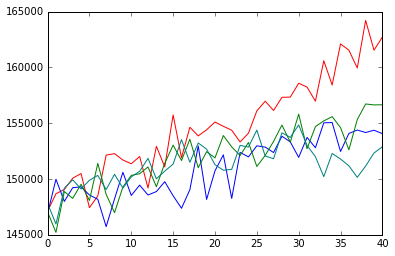

In [101]:
e=wstrp(dct,"9")
e['8.5']
m85=e['8.5'].mean(axis=1)
m60=e['6.0'].mean(axis=1)
m45=e['4.5'].mean(axis=1)
m26=e['2.6'].mean(axis=1)
plt.plot(m85,color='red')
plt.plot(m60,color='blue')
plt.plot(m45,color='green')
plt.plot(m26,color='teal')

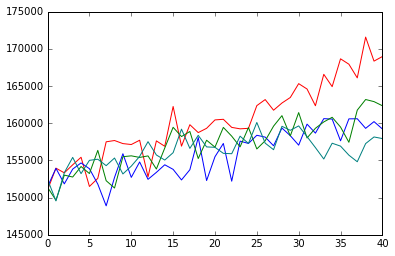

In [102]:
f=wstrp(dct,"14")
f['8.5']
mf85=f['8.5'].mean(axis=1)
mf60=f['6.0'].mean(axis=1)
mf45=f['4.5'].mean(axis=1)
mf26=f['2.6'].mean(axis=1)
plt.plot(mf85,color='red')
plt.plot(mf60,color='blue')
plt.plot(mf45,color='green')
plt.plot(mf26,color='teal')

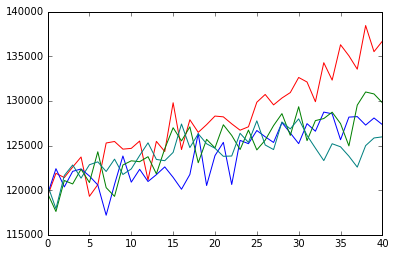

In [103]:
g=wstrp(dct,"16")
g['8.5']
mg85=g['8.5'].mean(axis=1)
mg60=g['6.0'].mean(axis=1)
mg45=g['4.5'].mean(axis=1)
mg26=g['2.6'].mean(axis=1)
plt.plot(mg85,color='red')
plt.plot(mg60,color='blue')
plt.plot(mg45,color='green')
plt.plot(mg26,color='teal')

In [119]:
g["8.5"].mean(axis=1).head()

2020-12-31    119343.469840
2021-12-31    121885.607291
2022-12-31    121412.213878
2023-12-31    122590.226481
2024-12-31    123714.214119
Freq: A-DEC, dtype: float64

In [120]:
f["8.5"].mean(axis=1).head()

2020-12-31    151045.556253
2021-12-31    153956.617540
2022-12-31    153328.605726
2023-12-31    154405.162756
2024-12-31    155421.352175
Freq: A-DEC, dtype: float64

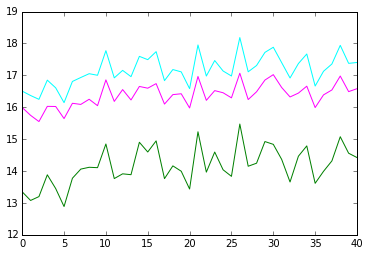

In [105]:
output=drybulbtemp(2020,2060,'RCP2.6/mir',1)
plt.plot(output["9"].resample('A'),color='cyan')
plt.plot(output["16"].resample('A'),color='green')
plt.plot(output["6"].resample('A'),color='magenta')

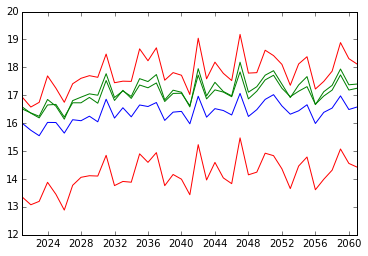

In [112]:
temp=output.sort().resample('a')
y=temp["6"]
y1=temp["8"]
y2=temp["9"]
y3=temp["14"]
y4=temp["16"]
x=temp.index
plt.plot(x,y)
plt.plot(x,y1)
plt.plot(x,y2,color='green')
plt.plot(x,y3,color='red')
plt.plot(x,y4)

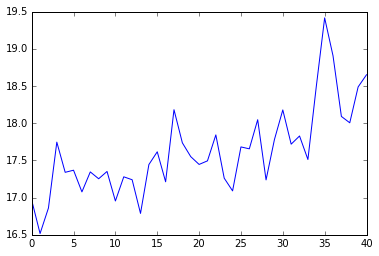

In [36]:
output=drybulbtemp(2020,2060,'RCP8.5/mir',1)
plot(output["9"].resample('A'))